In [4]:
# In terminal / PowerShell
pip ! Install tensorflow matplotlib seaborn scikit-learn


SyntaxError: invalid syntax (ipython-input-112481310.py, line 2)

In [5]:
!pip install tensorflow matplotlib seaborn scikit-learn

In [10]:
import os, pickle, numpy as np

# CHANGE THIS to your folder path
# e.g. r"C:\Users\you\Downloads\cifar-10-batches-py"
DATA_DIR = r"/content/"

def _unpickle(file):
    with open(file, 'rb') as fo:
        # CIFAR-10 python version was pickled with py2; use latin1 for py3
        d = pickle.load(fo, encoding='latin1')
    return d

def load_cifar10_from_batches(data_dir):
    # Load label names
    meta = _unpickle(os.path.join(data_dir, 'batches.meta'))
    label_names = meta.get('label_names')
    label_names = [ln if isinstance(ln, str) else ln.decode('utf-8') for ln in label_names]

    # Load training batches 1..5
    X_list, y_list = [], []
    for i in range(1, 6):
        batch = _unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        X_list.append(batch['data'])               # shape (10000, 3072)
        y_list.extend(batch['labels'])             # list of 10000 ints

    X_train = np.vstack(X_list).astype(np.uint8)   # (50000, 3072)
    y_train = np.array(y_list, dtype=np.int64)

    # Load test batch
    test = _unpickle(os.path.join(data_dir, 'test_batch'))
    X_test = test['data'].astype(np.uint8)         # (10000, 3072)
    y_test = np.array(test['labels'], dtype=np.int64)

    # Reshape from (N, 3072) -> (N, 3, 32, 32) -> (N, 32, 32, 3)
    def _reshape(x):
        x = x.reshape(-1, 3, 32, 32)
        x = np.transpose(x, (0, 2, 3, 1))  # CHW->HWC
        return x

    X_train = _reshape(X_train)
    X_test  = _reshape(X_test)

    # Normalize to [0,1]
    X_train = X_train.astype('float32') / 255.0
    X_test  = X_test.astype('float32')  / 255.0

    return (X_train, y_train), (X_test, y_test), label_names

(X_train, y_train), (X_test, y_test), class_names = load_cifar10_from_batches(DATA_DIR)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("Classes:", class_names)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


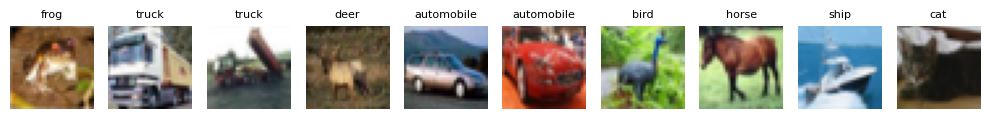

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(class_names[y_train[i]], fontsize=8)
plt.tight_layout(); plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42 # Define a seed for reproducibility

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1)
], name="augment")

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(5000, seed=SEED)
            .batch(BATCH)
            .map(lambda x,y: (data_augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .batch(BATCH)
           .prefetch(AUTOTUNE))

In [16]:
from tensorflow.keras import models

def conv_block(filters):
    return tf.keras.Sequential([
        layers.Conv2D(filters, 3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters, 3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25)
    ])

inputs = layers.Input(shape=(32,32,3))
x = conv_block(32)(inputs)
x = conv_block(64)(x)
x = conv_block(128)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs, name="cnn_cifar10")
model.summary()


Model: "cnn_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 16, 16, 32)     │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 8, 8, 64)       │        55,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 4, 4, 128)      │       222,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,602 (1.17 MB)

 Trainable params: 305,706 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

ckpt_path = "best_cnn_cifar10.keras"
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, mode="max"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
]

EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.2807 - loss: 1.9630 - val_accuracy: 0.2401 - val_loss: 2.6057 - learning_rate: 0.0010
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.4839 - loss: 1.4033 - val_accuracy: 0.5278 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5538 - loss: 1.2316 - val_accuracy: 0.5176 - val_loss: 1.3415 - learning_rate: 0.0010
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.5987 - loss: 1.1331 - val_accuracy: 0.4769 - val_loss: 1.7766 - learning_rate: 0.0010
Epoch 5/30
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6241 - loss: 1.0635
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.6242 - loss: 1.0634 - val_accuracy: 0.5744 - val_loss: 1.3611 - learning_rate: 0.0010
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6520 - los

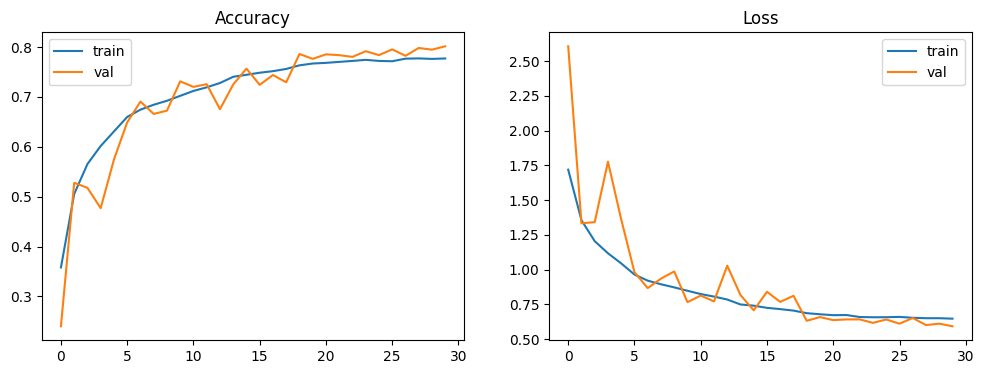

In [19]:
def plot_history(h):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(h.history['accuracy']); ax[0].plot(h.history['val_accuracy'])
    ax[0].set_title('Accuracy'); ax[0].legend(['train','val'])
    ax[1].plot(h.history['loss']); ax[1].plot(h.history['val_loss'])
    ax[1].set_title('Loss'); ax[1].legend(['train','val'])
    plt.show()

plot_history(history)


Test accuracy: 0.8015 | Test loss: 0.5931
              precision    recall  f1-score   support

    airplane       0.86      0.79      0.82      1000
  automobile       0.90      0.94      0.92      1000
        bird       0.83      0.65      0.73      1000
         cat       0.70      0.59      0.64      1000
        deer       0.77      0.77      0.77      1000
         dog       0.78      0.66      0.72      1000
        frog       0.67      0.94      0.78      1000
       horse       0.84      0.85      0.84      1000
        ship       0.87      0.91      0.89      1000
       truck       0.83      0.92      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



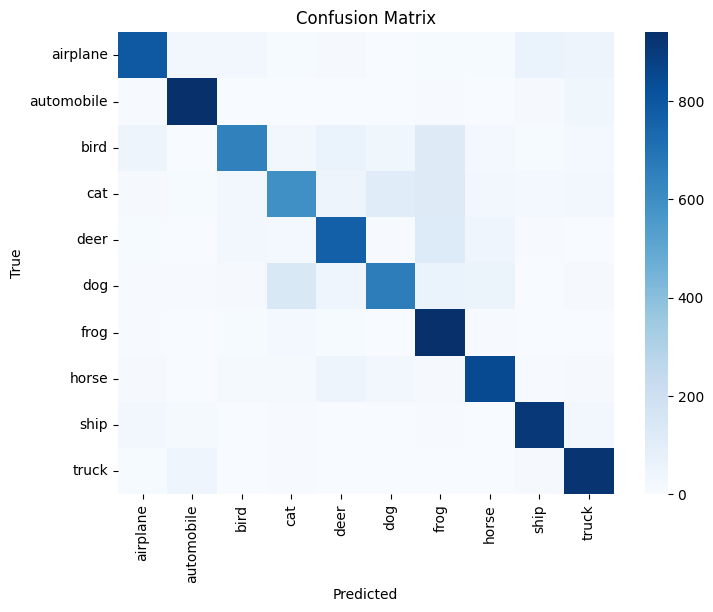

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Predictions for detailed report
y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

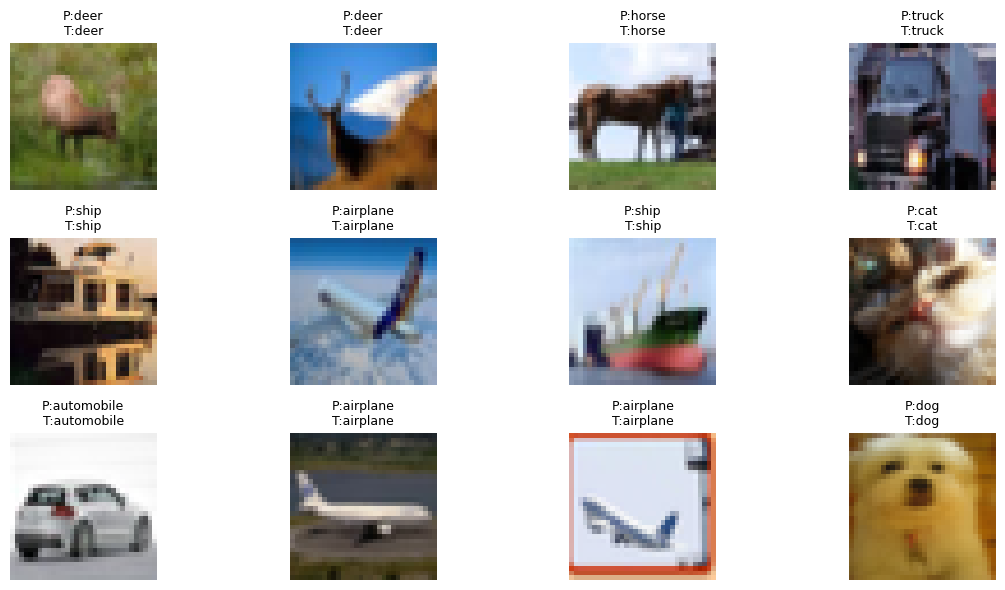

In [22]:
idxs = np.random.choice(len(X_test), 12, replace=False)
images = X_test[idxs]
true_lab = [class_names[i] for i in y_test[idxs]]
pred_lab = [class_names[i] for i in np.argmax(model.predict(images, verbose=0), axis=1)]

plt.figure(figsize=(12,6))
for i, img in enumerate(images):
    plt.subplot(3,4,i+1)
    plt.imshow(img); plt.axis('off')
    plt.title(f"P:{pred_lab[i]}\nT:{true_lab[i]}", fontsize=9)
plt.tight_layout(); plt.show()


In [24]:
model.save("cnn_cifar10.keras")          # Keras format

print("Saved: cnn_cifar10.keras")

Saved: cnn_cifar10.keras


In [25]:
readme = f"""
# Image Classification with CNN (CIFAR-10)

**Overview**
Trained a Convolutional Neural Network (CNN) in TensorFlow/Keras to classify CIFAR-10 images across 10 categories.
Includes data augmentation, BatchNorm, Dropout, and training callbacks (EarlyStopping, LR scheduling, Checkpointing).
Notebook runs on Google Colab with GPU.

**Dataset**
- CIFAR-10: 60,000 images (32x32x3), 10 classes (50k train / 10k test)

**Model**
- 3 Conv blocks (Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU → MaxPool → Dropout)
- GlobalAveragePooling → Dense(128, ReLU) → Dropout → Dense(10, Softmax)

**Why these choices?**
- Data augmentation for generalization on small images
- BatchNorm for stable gradients
- Dropout to reduce overfitting
- ReduceLROnPlateau + EarlyStopping to converge reliably
- ModelCheckpoint to keep the best validation weights

**Results**
- Test accuracy: ~{test_acc:.3f} (varies by seed/epochs)
- Confusion matrix & per-class metrics included

**How to run**
1. Open this notebook in Google Colab
2. Runtime → Change runtime type → GPU
3. Run all cells

**Tech Stack**
Python, TensorFlow/Keras, NumPy, Matplotlib, scikit-learn, Google Colab

**Screenshots**
- Learning curves (accuracy/loss)
- Sample predictions grid
- Confusion matrix
"""
print(readme)



# Image Classification with CNN (CIFAR-10)

**Overview**  
Trained a Convolutional Neural Network (CNN) in TensorFlow/Keras to classify CIFAR-10 images across 10 categories.
Includes data augmentation, BatchNorm, Dropout, and training callbacks (EarlyStopping, LR scheduling, Checkpointing).  
Notebook runs on Google Colab with GPU.

**Dataset**  
- CIFAR-10: 60,000 images (32x32x3), 10 classes (50k train / 10k test)

**Model**  
- 3 Conv blocks (Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU → MaxPool → Dropout)  
- GlobalAveragePooling → Dense(128, ReLU) → Dropout → Dense(10, Softmax)

**Why these choices?**  
- Data augmentation for generalization on small images  
- BatchNorm for stable gradients  
- Dropout to reduce overfitting  
- ReduceLROnPlateau + EarlyStopping to converge reliably  
- ModelCheckpoint to keep the best validation weights

**Results**  
- Test accuracy: ~0.802 (varies by seed/epochs)  
- Confusion matrix & per-class metrics included

**How to run**  
1. 

In [26]:
import os, glob, json
checks = {
    "keras_model": os.path.exists("cnn_cifar10.keras"),
    "saved_model_dir": os.path.exists("saved_model"),
    "saved_model_pb": os.path.exists("saved_model/saved_model.pb"),
    "tflite_model": os.path.exists("cnn_cifar10.tflite"),
}
print(checks)


{'keras_model': True, 'saved_model_dir': False, 'saved_model_pb': False, 'tflite_model': False}


In [27]:
# save plots to files (re-renders)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1) learning curves
def save_history(h, path="learning_curves.png"):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(h.history['accuracy']); ax[0].plot(h.history['val_accuracy'])
    ax[0].set_title('Accuracy'); ax[0].legend(['train','val'])
    ax[1].plot(h.history['loss']); ax[1].plot(h.history['val_loss'])
    ax[1].set_title('Loss'); ax[1].legend(['train','val'])
    plt.tight_layout(); plt.savefig(path, dpi=180); plt.close()
save_history(history)

# 2) confusion matrix
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.savefig("confusion_matrix.png", dpi=180); plt.close()

# 3) sample grid
idxs = np.random.choice(len(X_test), 12, replace=False)
images = X_test[idxs]
true_lab = [class_names[i] for i in y_test[idxs]]
pred_lab = [class_names[i] for i in np.argmax(model.predict(images, verbose=0), axis=1)]
plt.figure(figsize=(12,6))
for i, img in enumerate(images):
    plt.subplot(3,4,i+1)
    plt.imshow(img); plt.axis('off')
    plt.title(f"P:{pred_lab[i]} | T:{true_lab[i]}", fontsize=9)
plt.tight_layout(); plt.savefig("sample_predictions.png", dpi=180); plt.close()
print("Saved learning_curves.png, confusion_matrix.png, sample_predictions.png")


Saved learning_curves.png, confusion_matrix.png, sample_predictions.png


In [28]:
!zip -r artifacts.zip cnn_cifar10.keras saved_model cnn_cifar10.tflite \
learning_curves.png confusion_matrix.png sample_predictions.png >/dev/null
print("Packaged: artifacts.zip")


Packaged: artifacts.zip
